In [1]:
import csv
import os
import zipfile

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
zip_file_path = './task2.zip'
extraction_directory = 'extracted_images/'

if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)
    
print(f"Files extracted to {extraction_directory}")

In [3]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')

In [4]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')

In [5]:
X_train.drop(index = y_train[y_train['y']==3].index, inplace=True)

y_train.drop(index = y_train[y_train['y']==3].index, inplace=True)

In [6]:
index_to_drop = y_train[(y_train['y']==0) & ((-X_train.T.isna()).sum() <8350)].index

X_train.drop(index = index_to_drop, inplace=True)

y_train.drop(index = index_to_drop, inplace=True)

In [7]:
class_distribution = y_train.apply(lambda x: {'Class ' + str(i): x[x == i].count() / X_train.shape[0] for i in range(4)})['y']
for name in class_distribution:
    print(name + ': {:.2%}'.format(class_distribution[name]))

Class 0: 44.69%
Class 1: 12.78%
Class 2: 42.53%
Class 3: 0.00%


In [8]:
measure_length = (-X_train.T.isna()).sum().sort_values(ascending=True)

<Axes: >

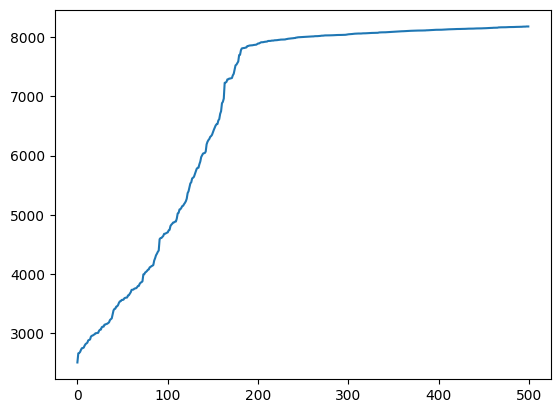

In [9]:
measure_length.head(500).reset_index()[0].plot()

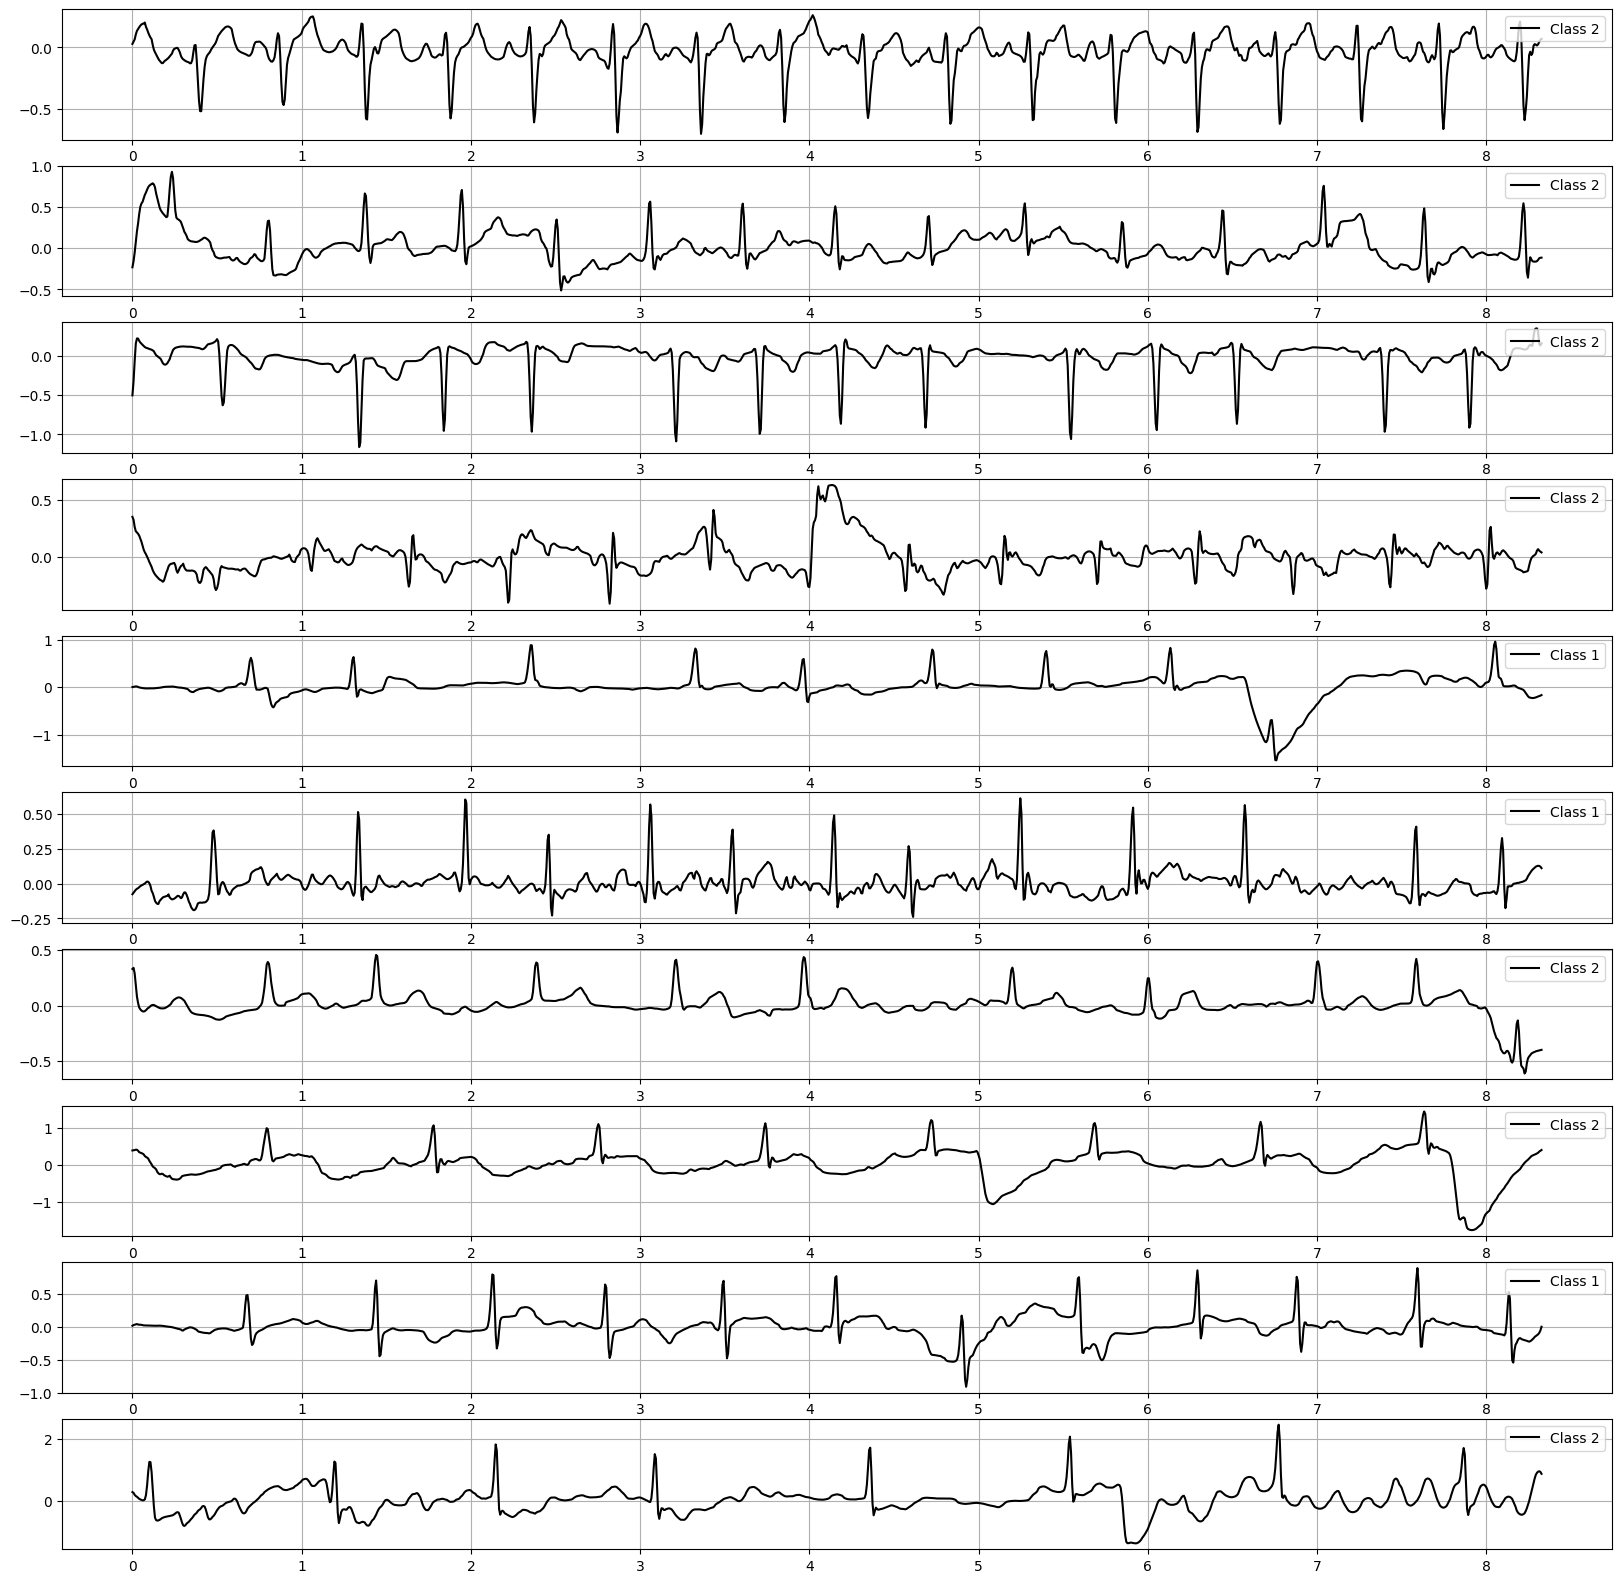

In [10]:
num = 10
plot_length = 2500

fig, axs = plt.subplots(num, 1, figsize=(20, 2*num))

seconds = np.arange(0, plot_length/2) / 150
x_labels = range(0, int(seconds[-1])+1)

for i, ind in enumerate(measure_length.head(num).index):
    ax = axs[i]
    
    measurements = X_train.loc[ind].fillna(0).to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[0:plot_length:2] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k', label='Class ' + str(y_train.loc[ind]['y']))
    ax.legend(loc='upper right')
    ax.set_xticks(x_labels)
    ax.grid()

num = 50
plot_length = 3000

fig, axs = plt.subplots(num, 1, figsize=(20, 2*num))

seconds = np.arange(0, plot_length/10) / 30
x_labels = range(0, int(seconds[-1])+1)

for i, ind in enumerate(measure_length.iloc[num:2*num:1].index):
    ax = axs[i]
    
    measurements = X_train.iloc[ind].fillna(0).to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[0:plot_length:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k', label='Class ' + str(y_train.iloc[ind]['y']))
    ax.legend(loc='upper right')
    ax.set_xticks(x_labels)
    ax.grid()

In [11]:
X_train_downsampled = X_train.iloc[:,range(0, X_train.shape[1], 2)]

measure_length_downsampled = (-X_train_downsampled.T.isna()).sum().sort_values(ascending=True)

<Axes: >

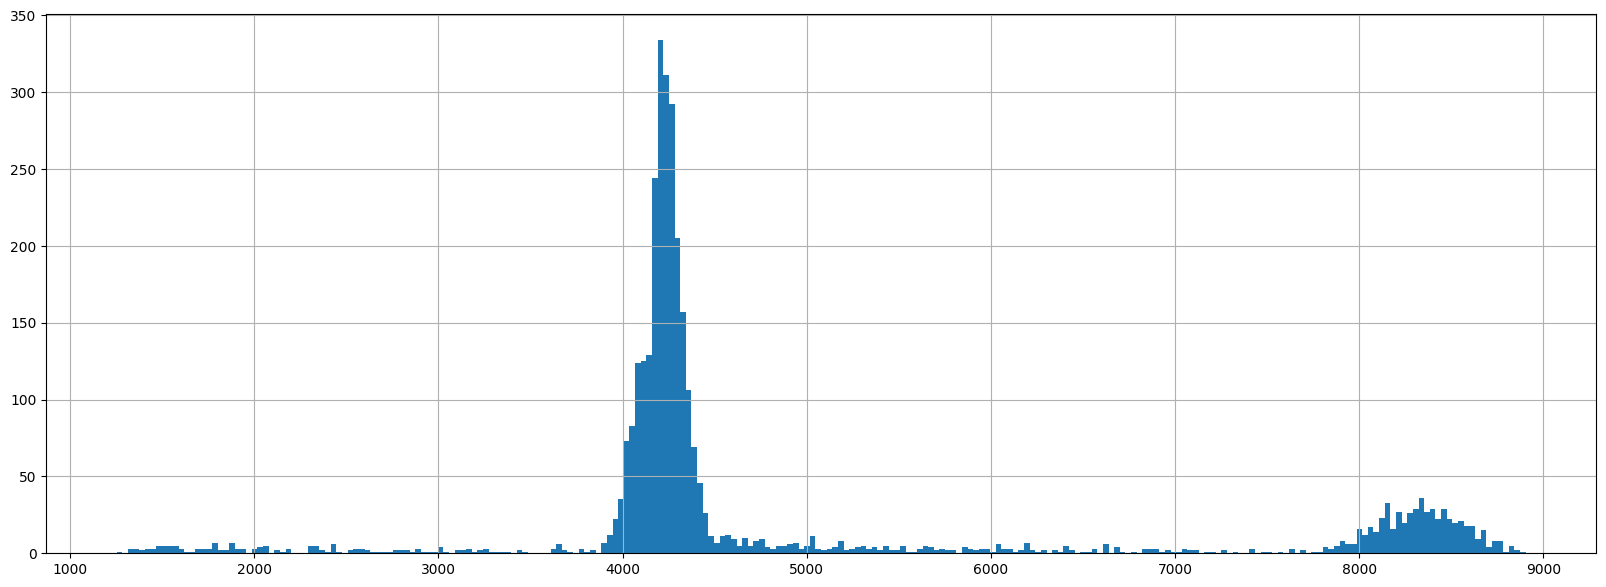

In [12]:
measure_length_downsampled.hist(bins=250, figsize=(20,7))

In [13]:
import time

length = measure_length_downsampled.iloc[0]

start = time.time()

X_train1_np = np.zeros((measure_length_downsampled.shape[0], length))
X_train_downsampled_np = X_train_downsampled.to_numpy()

for ind in range(X_train_downsampled.shape[0]):
    first_timestep = (measure_length_downsampled.loc[X_train_downsampled.index[ind]] - length) // 2
    last_timestep = first_timestep + length
    X_train1_np[ind,:] = X_train_downsampled_np[ind,first_timestep:last_timestep]

X_train1 = pd.DataFrame(data=X_train1_np, index=X_train_downsampled.index)

end = time.time()
print(end - start)

0.050523996353149414


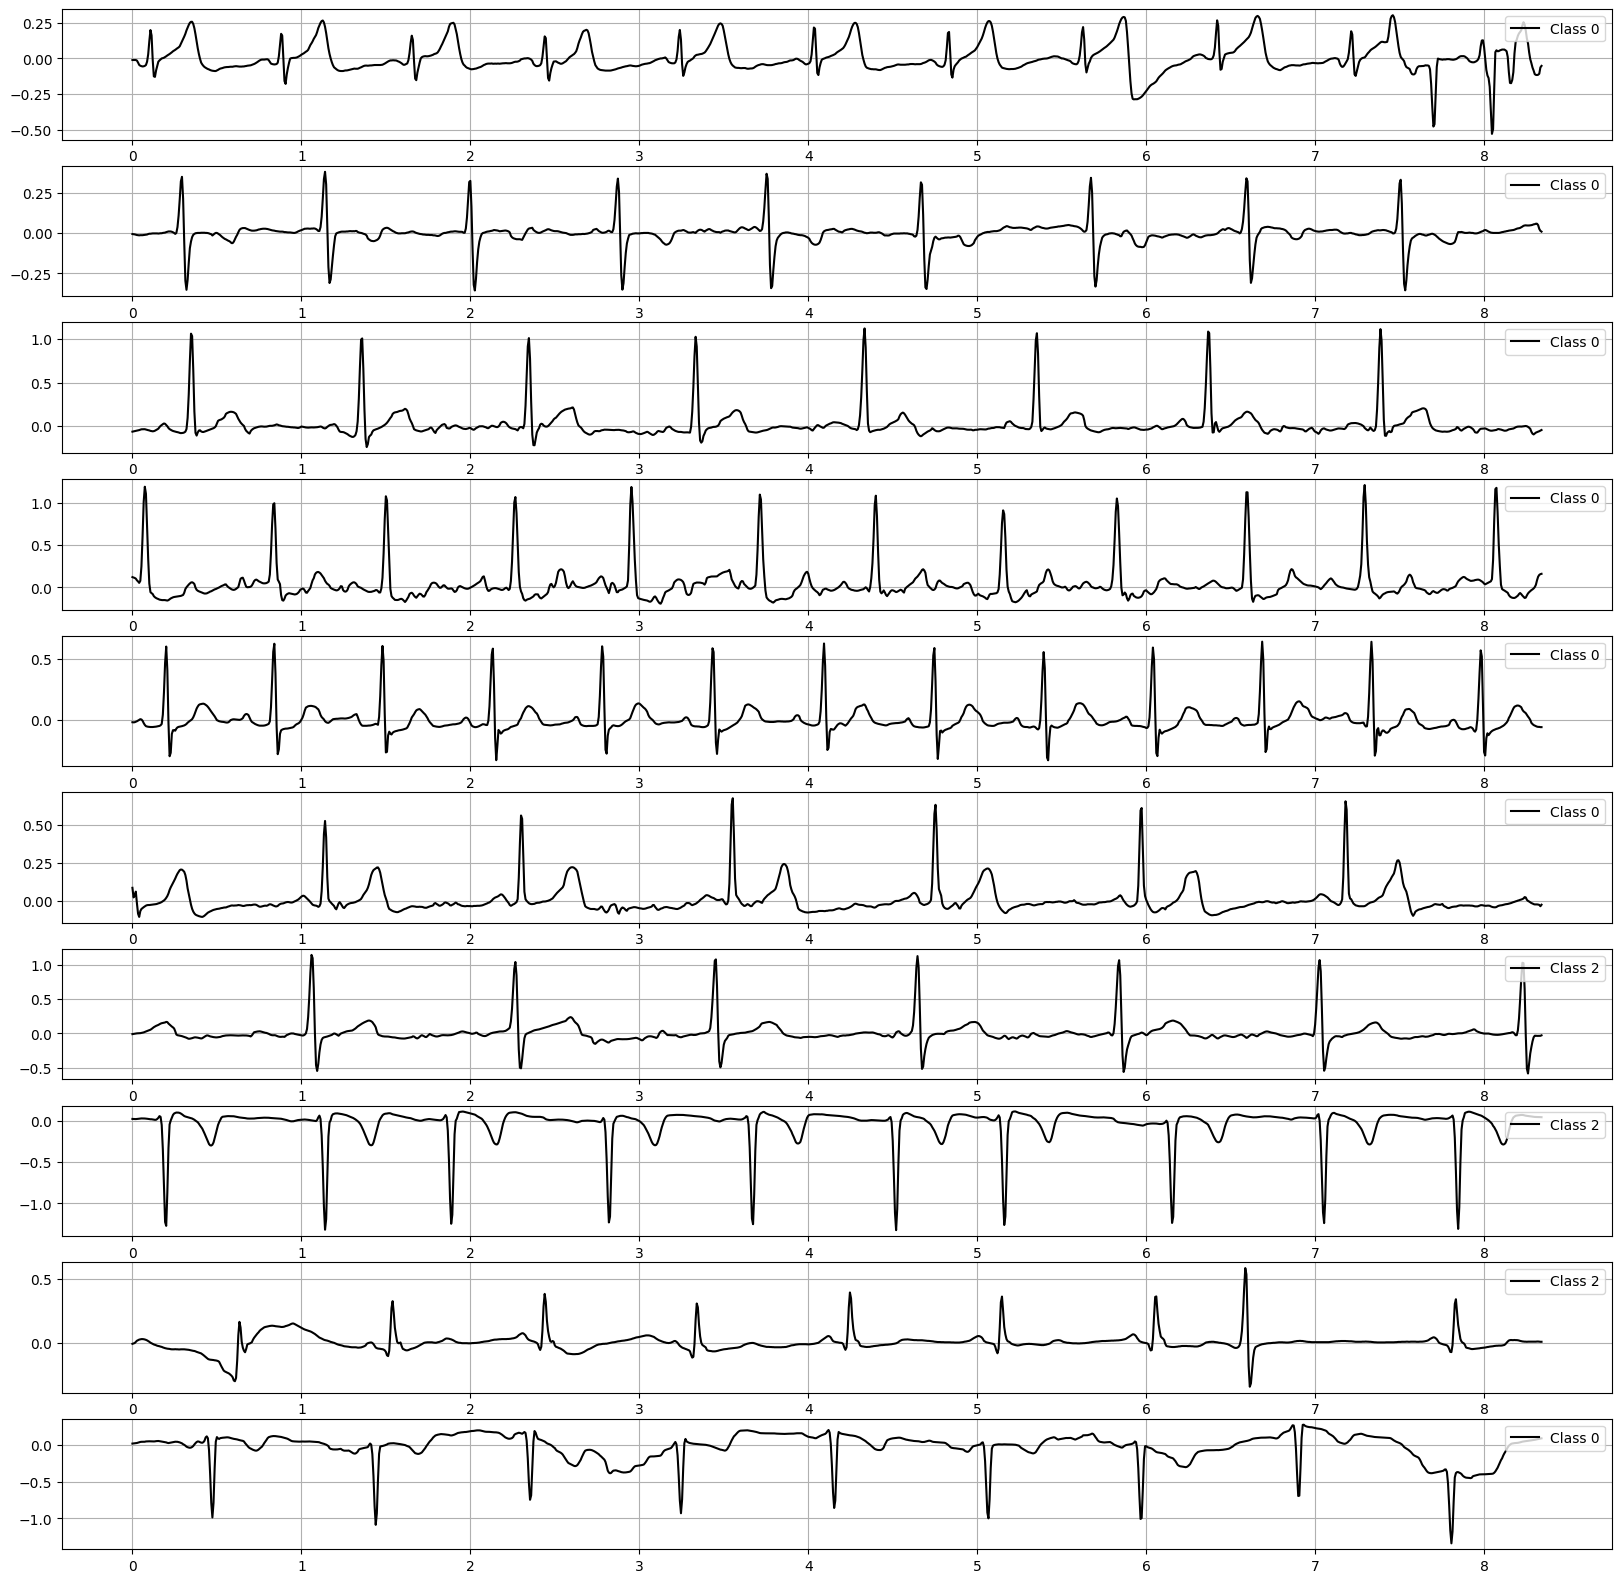

In [14]:
num = 10

fig, axs = plt.subplots(num, 1, figsize=(20, 2*num))

seconds = np.arange(0, length) / 150
x_labels = range(0, int(seconds[-1])+1)

for i, ind in enumerate(measure_length.tail(num).index):
    ax = axs[i]
    measurements = X_train1.loc[ind].to_numpy() / 1000
    ax.plot(seconds, measurements, color='k', label='Class ' + str(y_train.loc[ind]['y']))
    ax.legend(loc='upper right')
    ax.set_xticks(x_labels)
    ax.grid()

In [15]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_transformed_np = scaler.fit_transform(X_train1.to_numpy())

In [16]:
X_train_transformed = pd.DataFrame(data=X_train_transformed_np, index=X_train1.index)

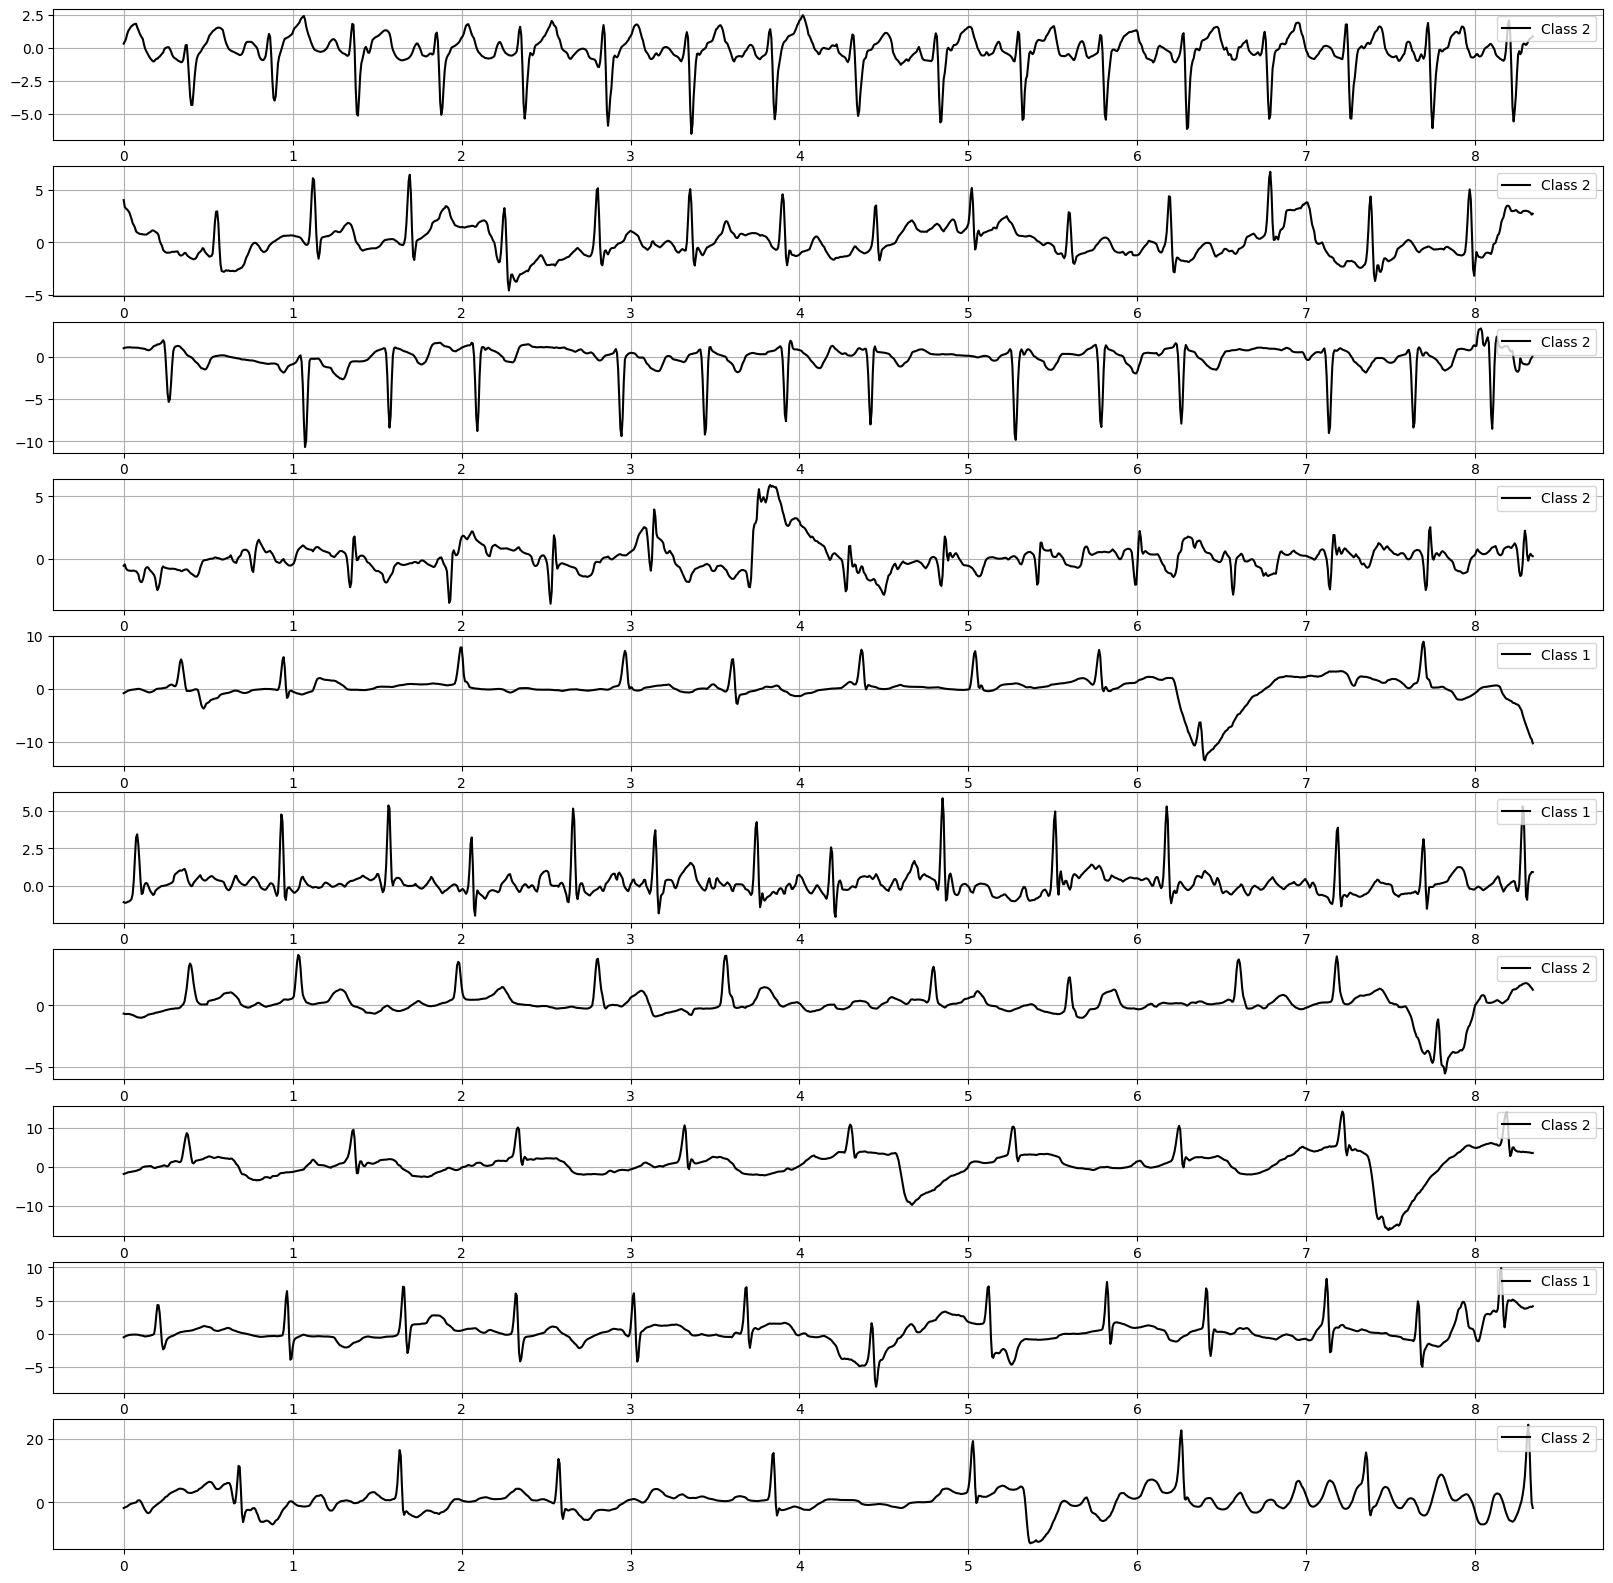

In [17]:
num = 10

fig, axs = plt.subplots(num, 1, figsize=(20, 2*num))

seconds = np.arange(0, length) / 150
x_labels = range(0, int(seconds[-1])+1)

for i, ind in enumerate(measure_length.head(num).index):
    ax = axs[i]
    measurements = X_train_transformed.loc[ind].to_numpy()
    ax.plot(seconds, measurements, color='k', label='Class ' + str(y_train.loc[ind]['y']))
    ax.legend(loc='upper right')
    ax.set_xticks(x_labels)
    ax.grid()

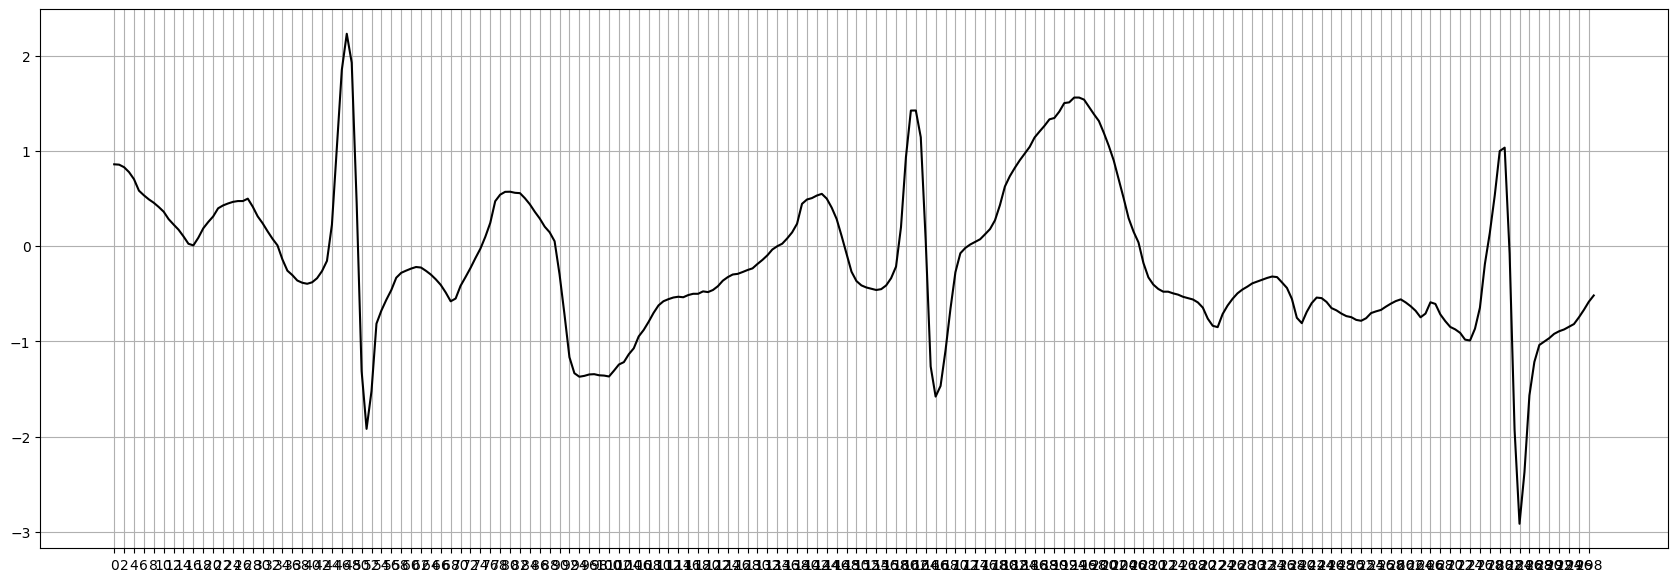

In [18]:
rg = 300

measurements = X_train_transformed.loc[1].to_numpy()[0:rg]
plt.figure(figsize =(21,7))
plt.plot(measurements, color='k', label='Class ' + str(y_train.loc[ind]['y']))
plt.xticks(range(0,rg,2));
plt.grid()

In [19]:
pd.unique(y_train['y'])

array([0, 1, 2])

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Input, Concatenate
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf

/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [21]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train.to_numpy())

# y_train_cat_np = y_train_cat_np[:, :, np.newaxis]
# X_train_transformed_np = X_train_transformed_np[:, :, np.newaxis]

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_transformed_np, y_train_cat_np, test_size=0.2, random_state=23)

In [22]:
X_train_partial.shape, y_train_partial.shape

((2772, 1252), (2772, 3))

# Define timesteps and the number of features

n_timesteps = 8

n_features = 7

# RNN + SLP Model

# Define input layer

recurrent_input = Input(shape=(n_timesteps,n_features),name=&amp;amp;amp;quot;TIMESERIES_INPUT&amp;amp;amp;quot;)

static_input = Input(shape=(x_train_over_static.shape[1], ),name=&amp;amp;amp;quot;STATIC_INPUT&amp;amp;amp;quot;)

# RNN Layers

# layer - 1

rec_layer_one = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),return_sequences=True),name =&amp;amp;amp;quot;BIDIRECTIONAL_LAYER_1&amp;amp;amp;quot;)(recurrent_input)

rec_layer_one = Dropout(0.1,name =&amp;amp;amp;quot;DROPOUT_LAYER_1&amp;amp;amp;quot;)(rec_layer_one)

# layer - 2

rec_layer_two = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),name =&amp;amp;amp;quot;BIDIRECTIONAL_LAYER_2&amp;amp;amp;quot;)(rec_layer_one)

rec_layer_two = Dropout(0.1,name =&amp;amp;amp;quot;DROPOUT_LAYER_2&amp;amp;amp;quot;)(rec_layer_two)

# SLP Layers

static_layer_one = Dense(64, kernel_regularizer=l2(0.001), activation='relu',name=&amp;amp;amp;quot;DENSE_LAYER_1&amp;amp;amp;quot;)(static_input)

# Combine layers - RNN + SLP

combined = Concatenate(axis= 1,name = &amp;amp;amp;quot;CONCATENATED_TIMESERIES_STATIC&amp;amp;amp;quot;)([rec_layer_two,static_layer_one])

combined_dense_two = Dense(64, activation='relu',name=&amp;amp;amp;quot;DENSE_LAYER_2&amp;amp;amp;quot;)(combined)

output = Dense(n_outputs,activation='sigmoid',name=&amp;amp;amp;quot;OUTPUT_LAYER&amp;amp;amp;quot;)(combined_dense_two)

# Compile Model

model = Model(inputs=[recurrent_input,static_input],outputs=[output])

# binary cross entropy loss

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

# focal loss

def focal_loss_custom(alpha, gamma):

def binary_focal_loss(y_true, y_pred):

fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)

y_true_K = K.ones_like(y_true)

focal_loss = fl(y_true, y_pred)

return focal_loss

return binary_focal_loss

model.compile(loss=focal_loss_custom(alpha=0.2, gamma=2.0), optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

# Model
model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape=(X_train_partial.shape[1], 1)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stop = EarlyStopping(patience=10)

# Train
model.fit(X_train_partial, y_train_partial, validation_data=(X_val, y_val), epochs=10, callbacks=[checkpoint, early_stop])


y_pred = to_categorical(model.predict(X_val).argmax(axis=1))
f1_score(y_val, y_pred, average='micro')

In [23]:
class_distribution = y_train.apply(lambda x: {'Class ' + str(i): x[x == i].count() / X_train.shape[0] for i in range(4)})['y']
for name in class_distribution:
    print(name + ': {:.2%}'.format(class_distribution[name]))

Class 0: 44.69%
Class 1: 12.78%
Class 2: 42.53%
Class 3: 0.00%


In [24]:
T = X_train_partial.shape[1]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 16, 16, 24, 16, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train_partial.shape[0]           # number of training examples (2D)
M_TEST = X_val.shape[0]             # number of test examples (2D),full=X_test.shape[0]
BATCH = M_TRAIN# // 8                          # batch size
EPOCH = 150                          # number of epochs
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.15                             # dropout rate
dropout_CNN = .3
recurrent_dropout = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, val_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {1}, epochs = {EPOCH}')
print(f'learning_rate = {learning_rate}, lambda = {LAMBD}, dropout = {dropout}, recurrent_dropout = {recurrent_dropout}')

layers=[32, 16, 16, 24, 16, 8, 3], train_examples=2772, val_examples=694
batch = 2772, timesteps = 1252, features = 1, epochs = 150
learning_rate = 0.005, lambda = 0.003, dropout = 0.15, recurrent_dropout = 0.0


In [169]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(.4))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=64, kernel_size=15, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=32, kernel_size=21, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=3, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_146 (Conv1D)         (None, 1250, 64)          256       
                                                                 
 dropout_212 (Dropout)       (None, 1250, 64)          0         
                                                                 
 conv1d_147 (Conv1D)         (None, 1246, 64)          20544     
                                                                 
 max_pooling1d_80 (MaxPooli  (None, 415, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_148 (Conv1D)         (None, 409, 64)           28736     
                                                                 
 dropout_213 (Dropout)       (None, 409, 64)           0         
                                                     

In [170]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/150


1/1 [==============================] - 4s 4s/step - loss: 1.3222 - accuracy: 0.3019 - auc_37: 0.4768 - val_loss: 1.1218 - val_accuracy: 0.4294 - val_auc_37: 0.5011
Epoch 2/150
1/1 [==============================] - 3s 3s/step - loss: 1.2553 - accuracy: 0.3286 - auc_37: 0.5045 - val_loss: 1.4157 - val_accuracy: 0.4294 - val_auc_37: 0.5070
Epoch 3/150
1/1 [==============================] - 3s 3s/step - loss: 1.2421 - accuracy: 0.3211 - auc_37: 0.4898 - val_loss: 2.6339 - val_accuracy: 0.4294 - val_auc_37: 0.5086
Epoch 4/150
1/1 [==============================] - 3s 3s/step - loss: 1.2043 - accuracy: 0.3449 - auc_37: 0.5024 - val_loss: 4.8387 - val_accuracy: 0.4294 - val_auc_37: 0.5203
Epoch 5/150
1/1 [==============================] - 3s 3s/step - loss: 1.1628 - accuracy: 0.3395 - auc_37: 0.5130 - val_loss: 6.5499 - val_accuracy: 0.4294 - val_auc_37: 0.5385
Epoch 6/150
1/1 [==============================] - 3s 3s/step - loss: 1.1547 - accuracy: 0.3770 - auc_37: 0.5365 - val_loss: 7.3048 

1/1 [==============================] - 0s 112ms/step - loss: 1.1510 - accuracy: 0.4207 - auc_30: 0.6752
-----------------------------------------------------------------
train accuracy = 42.2439%
test accuracy = 42.0749%
train AUC = 0.6782
test AUC = 0.6752


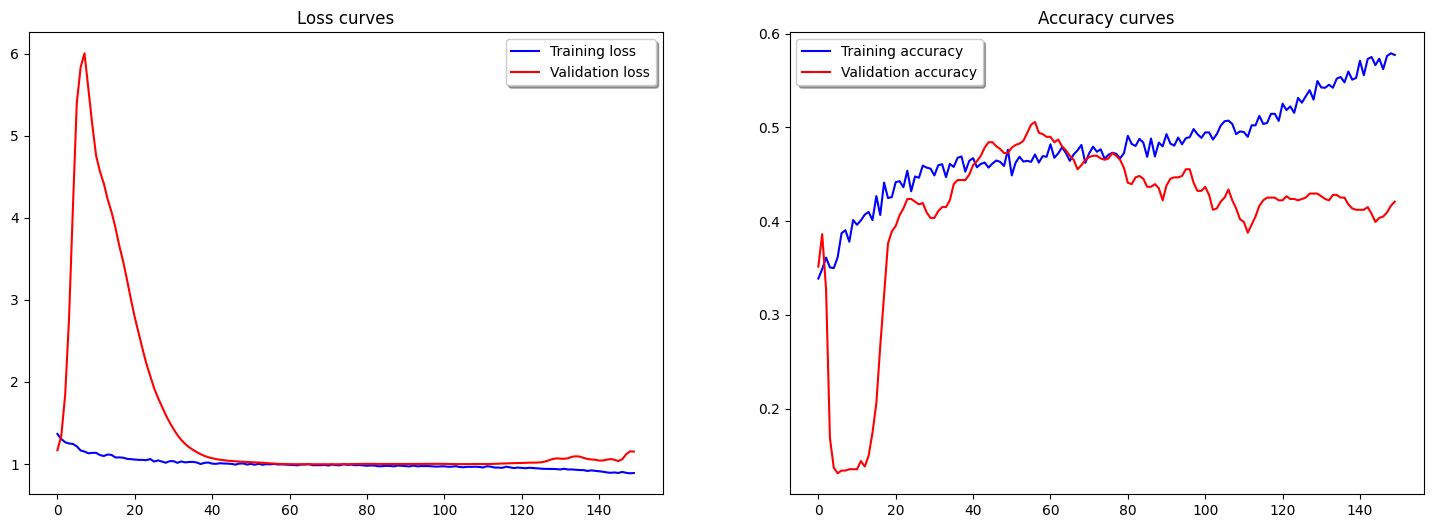

In [ ]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_84 (Conv1D)          (None, 1250, 48)          192       
                                                                 
 dropout_120 (Dropout)       (None, 1250, 48)          0         
                                                                 
 conv1d_85 (Conv1D)          (None, 1246, 48)          11568     
                                                                 
 max_pooling1d_84 (MaxPooli  (None, 415, 48)           0         
 ng1D)                                                           
                                                                 
 conv1d_86 (Conv1D)          (None, 409, 48)           16176     
                                                                 
 dropout_121 (Dropout)       (None, 409, 48)           0         
                                                        

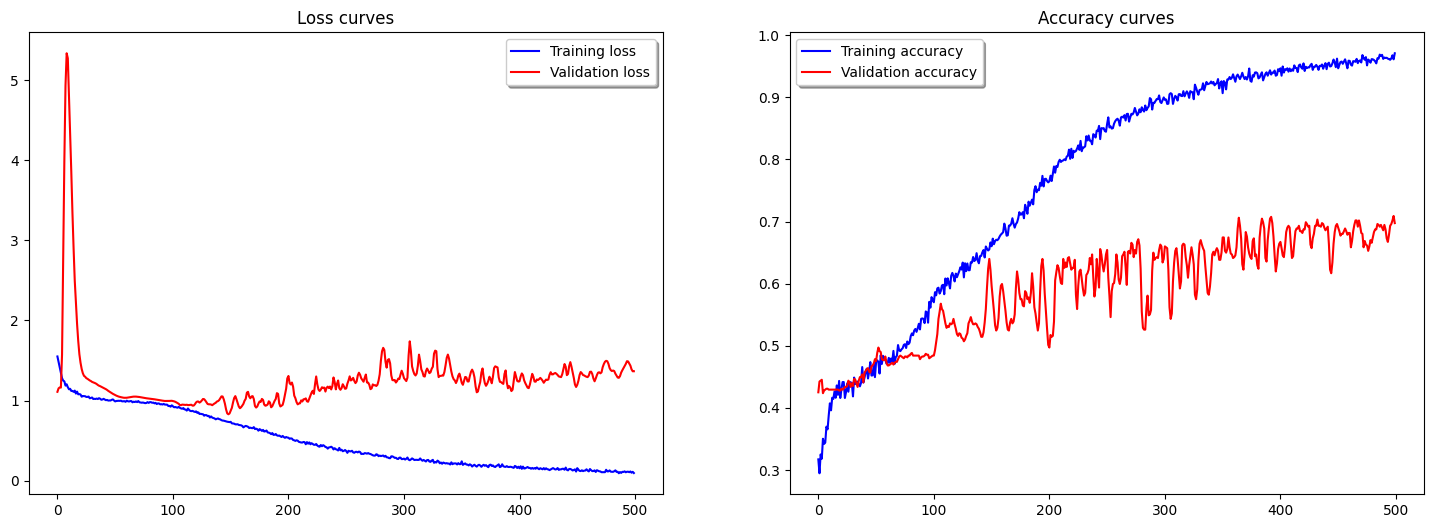

In [62]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=48, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(.4))
model.add(Conv1D(filters=48, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=48, kernel_size=7, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=48, kernel_size=9, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=48, kernel_size=15, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=48, kernel_size=21, activation='relu'))
model.add(Dropout(.4))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=3, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=500,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [102]:
y_pred = model.predict(X_val)
f1_score(y_val, to_categorical(y_pred.argmax(axis=1)), average='micro')

22/22 [==============================] - 0s 11ms/step


0.6974063400576369

In [84]:
(y_pred>.6).any(axis=1).sum() / y_pred.shape[0]

0.9596541786743515

In [85]:
X_test = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')

<Axes: >

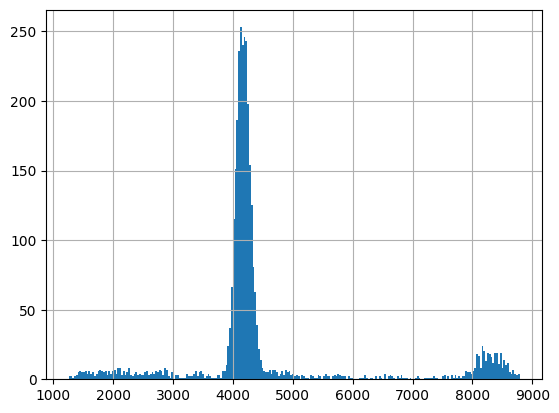

In [95]:
measure_length_test = (-X_test.T.isna()).sum().sort_values(ascending=True)
measure_length_test.hist(bins=250)

In [94]:
X_test_downsampled = X_test.iloc[:,range(0, X_test.shape[1], 2)]
assert X_test_downsampled.shape[1] == X_train_downsampled.shape[1]

measure_length_test_downsampled = (-X_test_downsampled.T.isna()).sum().sort_values(ascending=True)

In [97]:
start = time.time()

X_test1_np = np.zeros((measure_length_test_downsampled.shape[0], length))
X_test_downsampled_np = X_test_downsampled.to_numpy()

for ind in range(X_test_downsampled.shape[0]):
    first_timestep = (measure_length_test_downsampled.loc[X_test_downsampled.index[ind]] - length) // 2
    last_timestep = first_timestep + length
    X_test1_np[ind,:] = X_test_downsampled_np[ind,first_timestep:last_timestep]

X_test1 = pd.DataFrame(data=X_test1_np, index=X_test_downsampled.index)

end = time.time()
print(end - start)

0.05945420265197754


In [100]:
X_test_transformed_np = scaler.transform(X_test1)

In [120]:
y_pred = model.predict(X_test_transformed_np)

def mapping(x):
    for i in range(3):
        if x[i]>.55:
            return i
    return 3

y_pred_class_np = np.apply_along_axis(mapping, 1, y_pred)

107/107 [==============================] - 1s 11ms/step


In [122]:
sol = pd.DataFrame(data={'id': range(y_pred_class_np.shape[0]), 'y': y_pred_class_np})
sol.to_csv('sol.csv', columns=['id', 'y'], index = False)

In [60]:
n_timesteps, n_features, n_outputs = X_train_partial.shape[1], 1, 3

# head 1
inputs1 = Input(shape=(n_timesteps, n_features))
conv1 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=8, kernel_size=3, activation='relu')(inputs1)))
conv2 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=8, kernel_size=5, activation='relu')(conv1)))
conv3 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=8, kernel_size=7, activation='relu')(conv2)))
flat1 = Flatten()(conv3)
# head 2
inputs2 = Input(shape=(n_timesteps, n_features))
conv4 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=32, kernel_size=31, activation='relu')(inputs2)))
conv5 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=32, kernel_size=51, activation='relu')(conv4)))
conv6 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=32, kernel_size=71, activation='relu')(conv5)))
flat2 = Flatten()(conv6)
# merge
merged = tf.keras.layers.concatenate([flat1, flat2])
# interpretation
dense1 = Dense(32, activation='relu')(merged)
batchnorm1 = BatchNormalization()(dense1)
drop4 = Dropout(dropout)(batchnorm1)
dense2 = Dense(32, activation='relu')(drop4)
batchnorm2 = BatchNormalization()(dense2)
drop5 = Dropout(dropout)(batchnorm2)
dense3 = Dense(32, activation='relu')(drop5)
batchnorm3 = BatchNormalization()(dense3)
drop6 = Dropout(dropout)(batchnorm3)
dense4 = Dense(16, activation='relu')(drop6)
batchnorm4 = BatchNormalization()(dense4)
outputs = Dense(n_outputs, activation='softmax')(batchnorm4)
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

# save a plot of the model
tf.keras.utils.plot_model(model, show_shapes=True, to_file='multichannel.png')
# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 1252, 1)]            0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 1252, 1)]            0         []                            
                                                                                                  
 conv1d_78 (Conv1D)          (None, 1250, 8)              32        ['input_31[0][0]']            
                                                                                                  
 conv1d_81 (Conv1D)          (None, 1222,

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 1.2362 - accuracy: 0.3665 - auc_7: 0.5230 - val_loss: 1.3509 - val_accuracy: 0.1282 - val_auc_7: 0.3587
Epoch 2/150
1/1 [==============================] - 1s 1s/step - loss: 1.2014 - accuracy: 0.3835 - auc_7: 0.5345 - val_loss: 1.1587 - val_accuracy: 0.4222 - val_auc_7: 0.5611
Epoch 3/150
1/1 [==============================] - 1s 1s/step - loss: 1.1675 - accuracy: 0.3799 - auc_7: 0.5352 - val_loss: 2.0675 - val_accuracy: 0.4294 - val_auc_7: 0.5230
Epoch 4/150
1/1 [==============================] - 1s 1s/step - loss: 1.1283 - accuracy: 0.3936 - auc_7: 0.5535 - val_loss: 2.6659 - val_accuracy: 0.4294 - val_auc_7: 0.5928
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 1.1189 - accuracy: 0.3994 - auc_7: 0.5585 - val_loss: 3.1938 - val_accuracy: 0.4294 - val_auc_7: 0.5698
Epoch 6/150
1/1 [==============================] - 1s 1s/step - loss: 1.1123 - accuracy: 0.4026 - auc_7: 0.5658 - val_loss: 2.3433

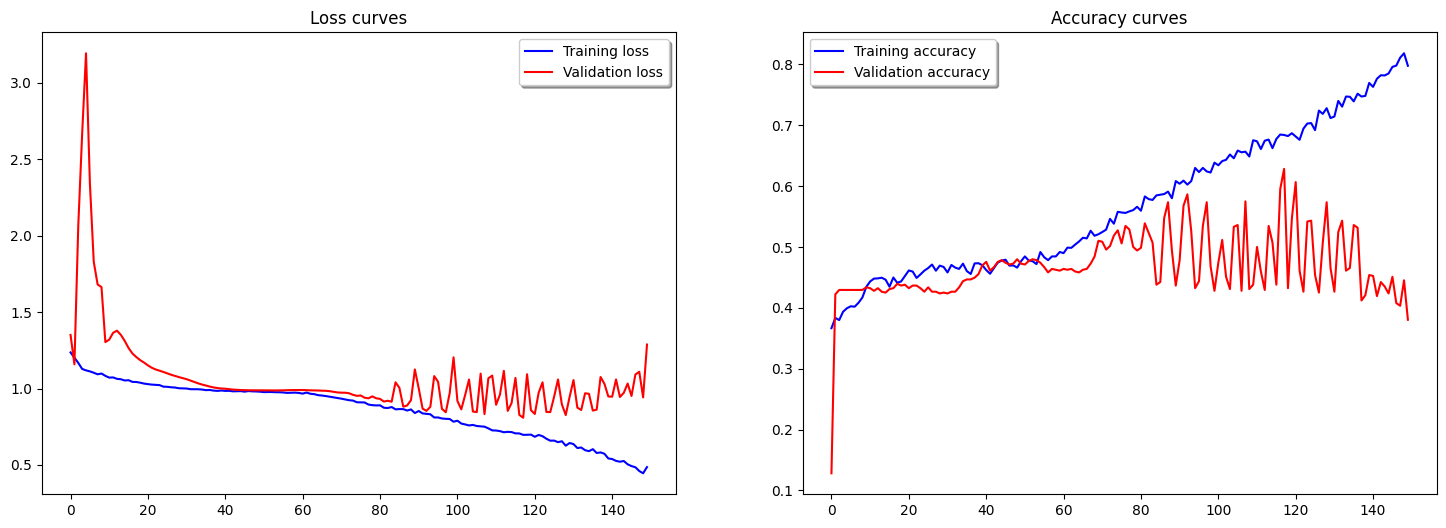

In [61]:
start = time.time()
History = model.fit([X_train_partial, X_train_partial],
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=([X_val[:M_TEST], X_val[:M_TEST]], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate([X_train_partial, X_train_partial],
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate([X_val[:M_TEST], X_val[:M_TEST]],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()


In [152]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=48, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(.4))
model.add(Conv1D(filters=48, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=16, kernel_size=15, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=16, kernel_size=21, activation='relu'))
model.add(Dropout(.4))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=3, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_95 (Conv1D)          (None, 1250, 48)          192       
                                                                 
 dropout_156 (Dropout)       (None, 1250, 48)          0         
                                                                 
 conv1d_96 (Conv1D)          (None, 1246, 48)          11568     
                                                                 
 max_pooling1d_52 (MaxPooli  (None, 415, 48)           0         
 ng1D)                                                           
                                                                 
 conv1d_97 (Conv1D)          (None, 409, 32)           10784     
                                                                 
 dropout_157 (Dropout)       (None, 409, 32)           0         
                                                     

In [142]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/150


1/1 [==============================] - 3s 3s/step - loss: 1.6229 - accuracy: 0.3160 - auc_21: 0.4860 - val_loss: 1.1270 - val_accuracy: 0.3329 - val_auc_21: 0.4417
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 1.4662 - accuracy: 0.3420 - auc_21: 0.5141 - val_loss: 1.1432 - val_accuracy: 0.3386 - val_auc_21: 0.4513
Epoch 3/150
1/1 [==============================] - 2s 2s/step - loss: 1.4285 - accuracy: 0.3366 - auc_21: 0.5104 - val_loss: 1.2204 - val_accuracy: 0.3271 - val_auc_21: 0.4401
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 1.3505 - accuracy: 0.3369 - auc_21: 0.5186 - val_loss: 1.2962 - val_accuracy: 0.3444 - val_auc_21: 0.4501
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 1.2960 - accuracy: 0.3521 - auc_21: 0.5289 - val_loss: 1.3662 - val_accuracy: 0.3991 - val_auc_21: 0.4878
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 1.2469 - accuracy: 0.3629 - auc_21: 0.5496 - val_loss: 1.5187 

1/1 [==============================] - 0s 104ms/step - loss: 0.8701 - accuracy: 0.6182 - auc_21: 0.8027
-----------------------------------------------------------------
train accuracy = 67.5325%
test accuracy = 61.8156%
train AUC = 0.8511
test AUC = 0.8027


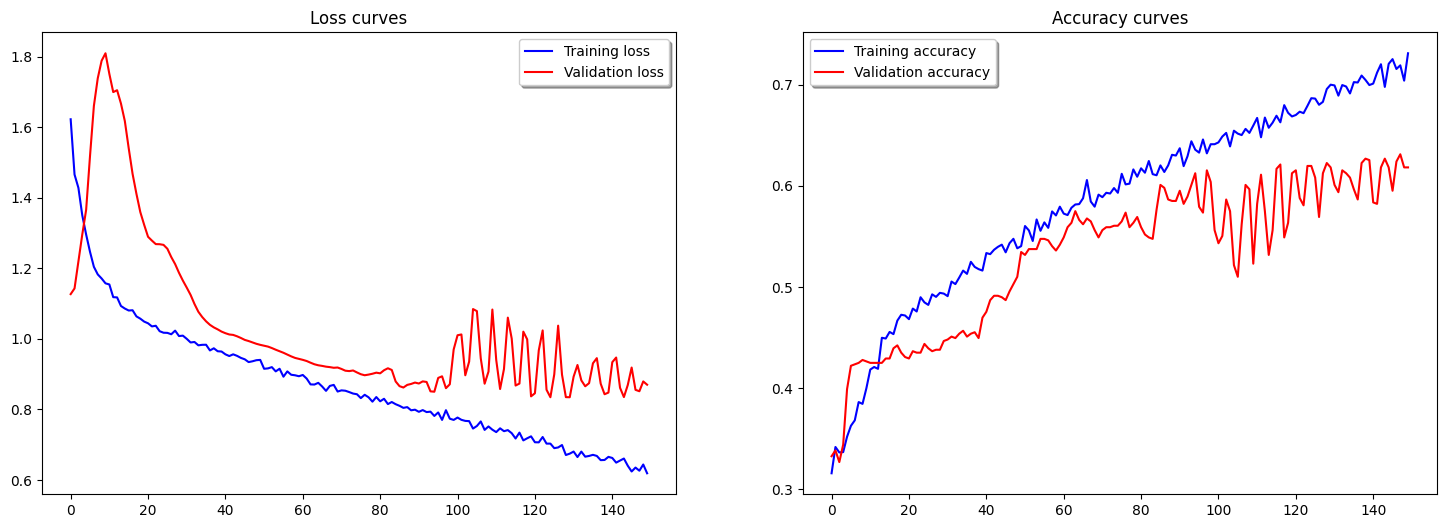

In [144]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

1/1 [==============================] - 0s 88ms/step - loss: 1.4278 - accuracy: 0.5274 - auc_12: 0.6535
-----------------------------------------------------------------
train accuracy = 86.2554%
test accuracy = 52.7378%
train AUC = 0.9703
test AUC = 0.6535


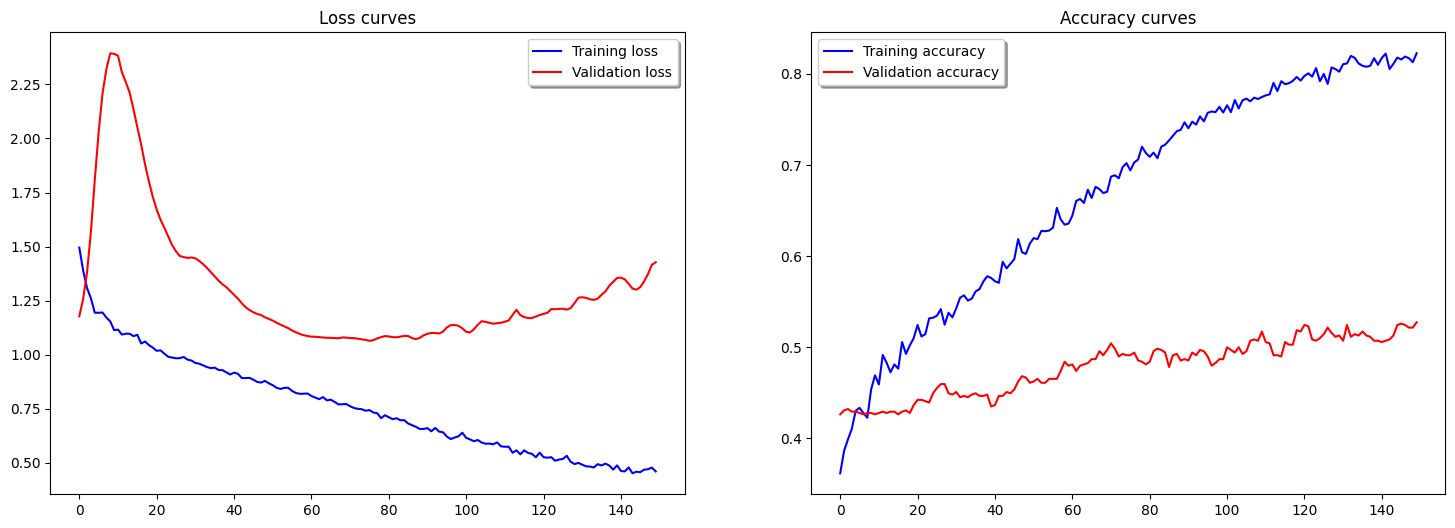

In [131]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [100]:
T = X_train_partial.shape[1]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 16, 24, 24, 16, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train_partial.shape[0]           # number of training examples (2D)
M_TEST = X_val.shape[0]             # number of test examples (2D),full=X_test.shape[0]
BATCH = M_TRAIN# // 8                          # batch size
EPOCH = 150                          # number of epochs
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.15                             # dropout rate
recurrent_dropout = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, val_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {1}, epochs = {EPOCH}')
print(f'learning_rate = {learning_rate}, lambda = {LAMBD}, dropout = {dropout}, recurrent_dropout = {recurrent_dropout}')

layers=[32, 16, 24, 24, 16, 8, 3], train_examples=2772, val_examples=694
batch = 2772, timesteps = 1252, features = 1, epochs = 150
learning_rate = 0.005, lambda = 0.003, dropout = 0.15, recurrent_dropout = 0.0


import tensorflow as tf
from keras import backend as K

def f1_score(y_true, y_pred):
    # Calculating the Precision and Recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculating F1 Score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [101]:
# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,1),
               units=LAYERS[0],
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD),
               recurrent_regularizer=l2(LAMBD),
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               return_sequences=True,
               return_state=False,
               stateful=False,
               unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD),
               recurrent_regularizer=l2(LAMBD),
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               return_sequences=False,
               return_state=False,
               stateful=False,
               unroll=False
              ))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[2], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[3], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[4], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[5], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[-1], activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=100,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1252, 32)          4352      
                                                                 
 batch_normalization_35 (Ba  (None, 1252, 32)          128       
 tchNormalization)                                               
                                                                 
 lstm_20 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_36 (Ba  (None, 16)                64        
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 24)               

In [102]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_acc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Epoch 1/150


1/1 [==============================] - 10s 10s/step - loss: 1.8968 - accuracy: 0.3099 - auc_8: 0.4880 - val_loss: 1.3685 - val_accuracy: 0.4424 - val_auc_8: 0.6428 - lr: 0.0050
Epoch 2/150
1/1 [==============================] - 8s 8s/step - loss: 1.7975 - accuracy: 0.3222 - auc_8: 0.5029 - val_loss: 1.3568 - val_accuracy: 0.4582 - val_auc_8: 0.6557 - lr: 0.0050
Epoch 3/150
1/1 [==============================] - 8s 8s/step - loss: 1.7202 - accuracy: 0.3308 - auc_8: 0.4986 - val_loss: 1.3459 - val_accuracy: 0.4539 - val_auc_8: 0.6554 - lr: 0.0050
Epoch 4/150
1/1 [==============================] - 8s 8s/step - loss: 1.6737 - accuracy: 0.3279 - auc_8: 0.5025 - val_loss: 1.3354 - val_accuracy: 0.4496 - val_auc_8: 0.6620 - lr: 0.0050
Epoch 5/150
1/1 [==============================] - 9s 9s/step - loss: 1.6068 - accuracy: 0.3398 - auc_8: 0.5146 - val_loss: 1.3251 - val_accuracy: 0.4481 - val_auc_8: 0.6646 - lr: 0.0050
Epoch 6/150
1/1 [==============================] - 9s 9s/step - loss: 1.600

InvalidParameterError: The 'y_pred' parameter of f1_score must be an array-like or a sparse matrix. Got 587 instead.

In [103]:
y_pred = to_categorical(model.predict(X_val).argmax(axis=1))
y_pred

22/22 [==============================] - 1s 53ms/step


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [104]:
f1_score(y_val, y_pred, average='micro')

0.45821325648414984

Epoch 1/50
9/9 [==============================] - 45s 5s/step - loss: 3.8726 - accuracy: 0.3911 - val_loss: 4.0207 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 2/50
9/9 [==============================] - 41s 5s/step - loss: 2.8266 - accuracy: 0.5616 - val_loss: 29.1877 - val_accuracy: 0.2754 - lr: 0.0500
Epoch 3/50
9/9 [==============================] - 40s 4s/step - loss: 2.6621 - accuracy: 0.5236 - val_loss: 6.7147 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 4/50
9/9 [==============================] - 40s 4s/step - loss: 2.1578 - accuracy: 0.5453 - val_loss: 2.7816 - val_accuracy: 0.2852 - lr: 0.0500
Epoch 5/50
9/9 [==============================] - 43s 5s/step - loss: 2.2244 - accuracy: 0.5081 - val_loss: 3.0780 - val_accuracy: 0.5508 - lr: 0.0500
Epoch 6/50
9/9 [==============================] - 42s 5s/step - loss: 2.4330 - accuracy: 0.5077 - val_loss: 2.6616 - val_accuracy: 0.5898 - lr: 0.0250
Epoch 7/50
9/9 [==============================] - 43s 5s/step - loss: 2.0176 - accuracy: 0.54

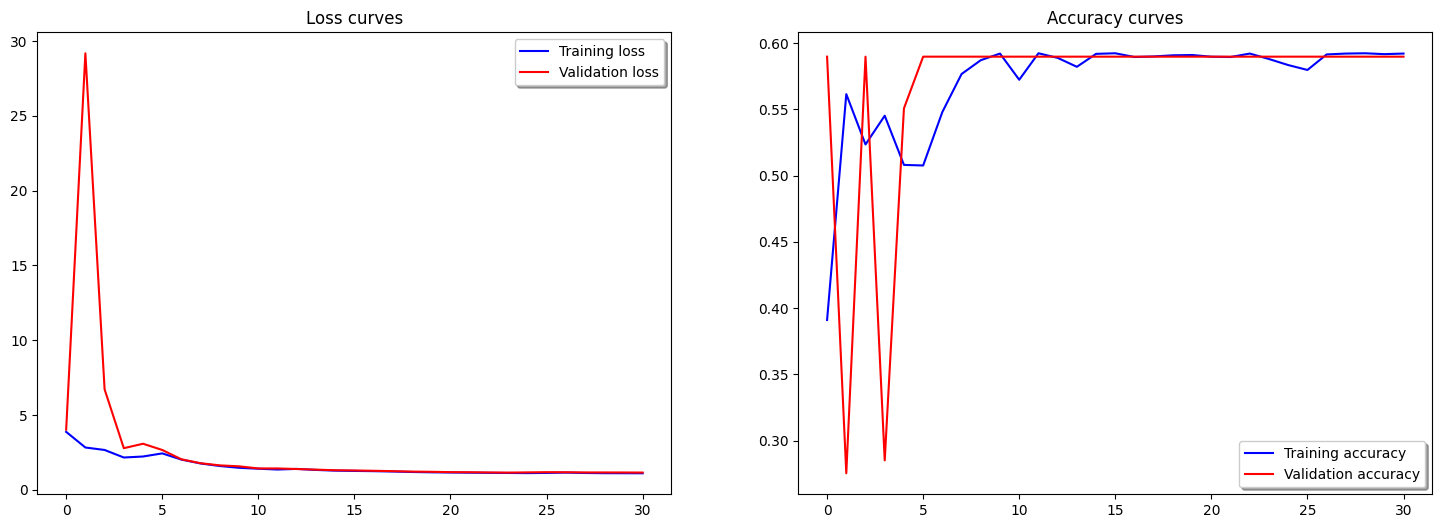

In [ ]:
start = time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_acc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Epoch 1/50
1/1 [==============================] - 89s 89s/step - loss: 13.7989 - accuracy: 0.2289 - val_loss: 9.7192 - val_accuracy: 0.4062 - lr: 0.0500
Epoch 2/50
1/1 [==============================] - 87s 87s/step - loss: 10.0856 - accuracy: 0.2743 - val_loss: 9.0830 - val_accuracy: 0.4219 - lr: 0.0500
Epoch 3/50
1/1 [==============================] - 86s 86s/step - loss: 9.3113 - accuracy: 0.3442 - val_loss: 9.3445 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 4/50
1/1 [==============================] - 85s 85s/step - loss: 9.4037 - accuracy: 0.4882 - val_loss: 9.6723 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 5/50
1/1 [==============================] - 86s 86s/step - loss: 9.6852 - accuracy: 0.5431 - val_loss: 9.3801 - val_accuracy: 0.5898 - lr: 0.0250
Epoch 6/50
1/1 [==============================] - 84s 84s/step - loss: 9.4050 - accuracy: 0.5874 - val_loss: 8.9714 - val_accuracy: 0.5898 - lr: 0.0125
Epoch 7/50
1/1 [==============================] - 84s 84s/step - loss: 9.0023 - accura

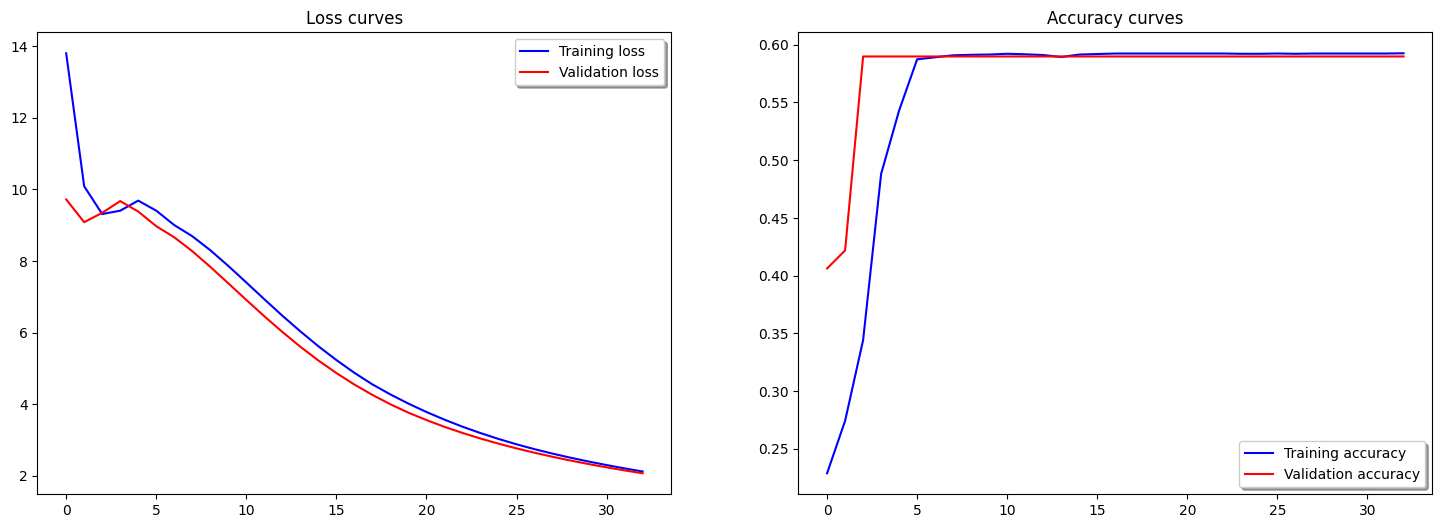

In [ ]:
start = time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_acc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

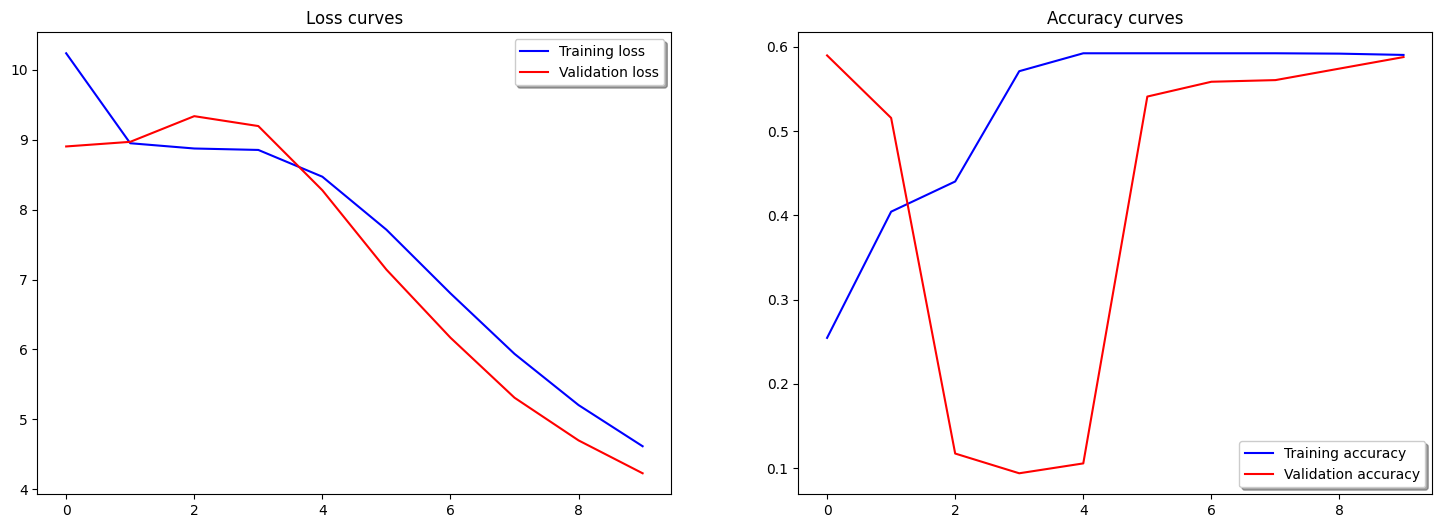